# Time Series Forecasting of BTC price with exogenous features

In this notebook I will be using exogenous features on top of the time series values to predict the BTC price. BTC price data had been obtained from this [dataset](https://www.kaggle.com/datasets/varpit94/bitcoin-data-updated-till-26jun2021) and tweets have been obtained from here.
Following preprocessing steps have been done on the Tweets data set.


1.   Remove null values
2.   Remove non English tweets
3.   Extract date and time of the tweets
4.   Drop tweets that have been publshed after 8:00 PM
5.   Clean the text part of the tweets
6.   Use sentiment analysis libraries (Huggin Face, Flair, TextBlob) to get the sentiment value of each tweet
7.   Obtain the average sentiment of tweets for each day.
8.   Join with the BTC price data set

Here we are loading the BTC price and the tweet sentiment value data set.

In [27]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
pd.__version__


'1.4.3'

In [28]:
from sklearn.metrics import mean_squared_error
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200 / (np.abs(y_pred) + np.abs(y_true))))

# Load data 



In [29]:
file_path = 'Data/tweets_sentiment_btc_usd_final_full.csv'
btc_df = pd.read_csv(file_path)
btc_df.drop('Unnamed: 0', axis=1,inplace=True)
btc_df.rename(columns = {'text':'num_tweets'}, inplace = True)
btc_df.info()
btc_df.index = pd.to_datetime(btc_df['Date'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1894 entries, 0 to 1893
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             1894 non-null   object 
 1   Open             1894 non-null   float64
 2   High             1894 non-null   float64
 3   Low              1894 non-null   float64
 4   Close            1894 non-null   float64
 5   Adj Close        1894 non-null   float64
 6   Volume           1894 non-null   int64  
 7   num_tweets       1894 non-null   int64  
 8   likes            1894 non-null   float64
 9   retweets         1894 non-null   float64
 10  replies          1894 non-null   float64
 11  tb_polarity      1894 non-null   float64
 12  tb_subjectivity  1894 non-null   float64
 13  vd_sentiment     1894 non-null   float64
dtypes: float64(11), int64(2), object(1)
memory usage: 207.3+ KB


In [30]:
btc_df.sample(10)

,Date,Open,High,Low,Close,Adj Close,Volume,num_tweets,likes,retweets,replies,tb_polarity,tb_subjectivity,vd_sentiment
Date,,,,,,,,,,,,,,
2019-07-11,2019-07-11,12139.713867,12144.623047,11158.922852,11358.662109,11358.662109,28595327690,94343,0.322917,0.322917,0.132495,0.052912,0.153121,0.066143
2017-02-01,2017-02-01,970.940979,989.114014,970.742004,989.023010,989.023010,150110000,165,0.200000,0.200000,0.000000,0.027959,0.114266,0.029616
2018-01-07,2018-01-07,17527.300781,17579.599609,16087.700195,16477.599609,16477.599609,15866000384,676,15.097633,15.097633,2.992604,0.034719,0.196787,0.031854
2015-06-14,2015-06-14,232.442001,234.858002,232.003998,233.542999,233.542999,12165900,332,0.310241,0.310241,0.009036,0.020417,0.283217,0.101904
2017-07-02,2017-07-02,2436.399902,2514.280029,2394.840088,2506.469971,2506.469971,803747008,225,0.222222,0.222222,0.040000,0.046422,0.154538,0.014206
2016-12-29,2016-12-29,975.125000,979.396973,954.502991,973.497009,973.497009,199320000,179,0.614525,0.614525,0.072626,0.045211,0.122707,0.030203
2016-10-12,2016-10-12,640.870972,641.336975,635.965027,636.192017,636.192017,92370200,227,0.343612,0.343612,0.061674,0.019934,0.092181,0.012051
2015-04-27,2015-04-27,219.429001,233.304993,218.022995,229.285995,229.285995,38574000,853,0.255569,0.255569,0.005862,0.013882,0.240601,0.071797
2015-01-14,2015-01-14,223.893997,223.893997,171.509995,178.102997,178.102997,97638704,507,0.794872,0.794872,0.067061,0.016388,0.157635,0.109798


Lets remove the unwanted columns and add the lagged values to the dataset. 


In [5]:

btc_df['lag_num_tweets'] = btc_df['num_tweets'].shift(1)
btc_df['lag_tb_subjectivity'] = btc_df['tb_subjectivity'].shift(1)
btc_df['lag_tb_polarity'] = btc_df['tb_polarity'].shift(1)
btc_df['lag_vd_sentiment'] = btc_df['vd_sentiment'].shift(1)
btc_df['lag_likes'] = btc_df['likes'].shift(1)
btc_df['lag_replies'] = btc_df['replies'].shift(1)
btc_df['lag_retweets'] = btc_df['retweets'].shift(1)

In [6]:
btc_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,num_tweets,likes,retweets,...,tb_polarity,tb_subjectivity,vd_sentiment,lag_num_tweets,lag_tb_subjectivity,lag_tb_polarity,lag_vd_sentiment,lag_likes,lag_replies,lag_retweets
Date,,,,,,,,,,,,,,,,,,,,,
2014-09-17,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800,412,0.570388,0.570388,...,0.026660,0.173957,0.120025,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-18,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200,424,0.429245,0.429245,...,0.020249,0.189769,0.127780,412.0,0.173957,0.026660,0.120025,0.570388,0.029126,0.570388
2014-09-19,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700,440,0.354545,0.354545,...,0.011647,0.217529,0.110965,424.0,0.189769,0.020249,0.127780,0.429245,0.004717,0.429245
2014-09-20,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600,439,0.416856,0.416856,...,0.022732,0.171126,0.121520,440.0,0.217529,0.011647,0.110965,0.354545,0.006818,0.354545
2014-09-21,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100,377,0.480106,0.480106,...,0.011460,0.172655,0.125047,439.0,0.171126,0.022732,0.121520,0.416856,0.002278,0.416856


####  Note: We are limiting our analysis on the open price of BTC.

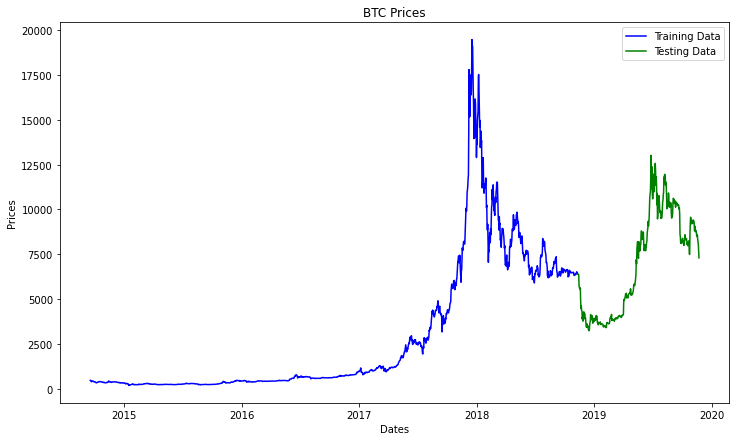

In [31]:
plt.figure(figsize=(12,7))
plt.title('BTC Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_data['Open'], 'blue', label='Training Data')
plt.plot(test_data['Open'], 'green', label='Testing Data')
plt.legend();

Now use the auto arima model we found to predict the resul 

# Time Series Forecasting with Deep Learning

Here we use LSTM for time series prediction.

In [32]:
# Let's load the libraries and dependencies for the deep learning model
from sklearn.preprocessing import MinMaxScaler

#%tensorflow_version 1.x
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD

## Build Train-Test Datasets

In [45]:
MSE=[];
SMAPE=[];
CaseNumber=[];
CaseFeatures=[];
features=['lag_num_tweets','lag_vd_sentiment','lag_tb_polarity','lag_tb_subjectivity','lag_likes','lag_replies','lag_retweets']
          
#features=['1','2','3'];

In [27]:
# Splitting the train and test set considering 'Open' feature from the dataset
#train_data, test_data = btc_price.iloc[0:int(len(btc_price)*0.8), :], btc_price.iloc[int(len(btc_price)*0.8):, :]
train_series = train_data['Open']
test_series = test_data['Open']
for i2 in range(2**len(features)):
    selector = f'{i2:0{len(features)}b}'
    CaseNumber.append(i2)
    usedFeatures=[];
    print(selector)
    print(type(selector))
    
    sc = MinMaxScaler(feature_range=(0,1))
    training_set_scaled = sc.fit_transform(train_data[['Open']])
    
    
    exoTrainSeries=[];
    exoTestSeries=[];
    exoScalerArr=[];
    
    
    for j in range(len(features)):
        if selector[j]=='1':
            tempTrain=train_data[features[j]];
            tempTest=test_data[features[j]];
            usedFeatures.append(features[j])
            tempSc = MinMaxScaler(feature_range=(0,1))
            train_set_scaled = tempSc.fit_transform(tempTrain.values.reshape(-1,1))
            
            
            train_last60 = tempTrain[-60:]
            new_test_series =  pd.concat([train_last60,tempTest],axis=0)
            print(new_test_series.shape)
            test_set_scaled = tempSc.fit_transform(new_test_series.values.reshape(-1,1))
    
    
            #test_set_scaled = tempSc.fit_transform(tempTest.values.reshape(-1,1))
            
            exoTrainSeries.append(train_set_scaled)
            exoTestSeries.append(test_set_scaled)
            exoScalerArr.append(tempSc)



    #1 output and 60 values inputs
    # So for each element of training set (output), we have 60 previous training set elements (input)
    X_train = []
    y_train = []
    X_test = []
    for i in range(60, len(training_set_scaled)):
        
        tempTrain=training_set_scaled[i-60:i,0]
        for k in range(len(exoTrainSeries)):
            tempTrain=np.append(tempTrain,exoTrainSeries[k][i])
            
        
        X_train.append(tempTrain)#;train_hf_sent_series[i]])
        y_train.append(training_set_scaled[i,0])
        
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train.shape, y_train.shape

    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1], 1))
    X_train.shape

  
    
     # Preparing X_test and predicting the prices
    train_last60 = train_series[-60:]
    print(train_last60.shape)
    test_series.shape
    
    new_test_series =  pd.concat([train_last60,test_series],axis=0)
    print(new_test_series.shape)
    test_set_scaled = sc.fit_transform(new_test_series.values.reshape(-1,1))
    
    
    
    for i in range(60,len(test_set_scaled)):
        tempTest=test_set_scaled[i-60:i,0]
        for k in range(len(exoTrainSeries)):
            tempTest=np.append(tempTest,exoTestSeries[k][i])
        
              
        X_test.append(tempTest)
    
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    X_test.shape

    

    
    
    regressor = Sequential()

    # First LSTM layer with Dropout regularisation
    regressor.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1],1)))
    regressor.add(Dropout(0.2))
    '''
    # Second LSTM layer
    regressor.add(LSTM(units=64, return_sequences=True,input_shape=(64,1)))
    regressor.add(Dropout(0.2))

    '''
    # Second LSTM layer
    regressor.add(LSTM(units=64, return_sequences=False,input_shape=(64,1)))
    regressor.add(Dropout(0.2))
    # The output layer
    regressor.add(Dense(units=1))

    # Compiling the RNN - optimizer(rmsprop)and loss(mean squared error)

    regressor.compile(optimizer='rmsprop',loss='mse')
    regressor.summary()


    regressor.fit(X_train,y_train, epochs=15, batch_size=64, validation_split=0.1, shuffle=True)

       

    predicted_stock_price = regressor.predict(X_test)
    print(X_test.shape)
    print(predicted_stock_price.shape)
    predicted_stock_price_revtrans = sc.inverse_transform(predicted_stock_price).ravel()
    predicted_stock_price_revtrans_series = pd.Series(predicted_stock_price_revtrans)
    predicted_stock_price_revtrans_series.index = test_series.index
    predicted_stock_price_revtrans_series.shape, test_series.shape

    # Evaluating our model
    error = mean_squared_error(test_series, predicted_stock_price_revtrans_series)
    print('Testing Mean Squared Error: %.3f' % error)
    #MSE.append(error)
    error2 = smape_kun(test_series, predicted_stock_price_revtrans_series)
    print('Symmetric Mean absolute percentage error: %.3f' % error2)
    
    MSE.append(error);
    SMAPE.append(error2)
    CaseFeatures.append('.'.join(usedFeatures));


0000000
<class 'str'>
(60,)
(439,)
Model: "sequential_258"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_516 (LSTM)             (None, 60, 64)            16896     
                                                                 
 dropout_516 (Dropout)       (None, 60, 64)            0         
                                                                 
 lstm_517 (LSTM)             (None, 64)                33024     
                                                                 
 dropout_517 (Dropout)       (None, 64)                0         
                                                                 
 dense_258 (Dense)           (None, 1)                 65        
                                                                 
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
21

In [28]:
temp={"Case":CaseNumber,"Features":CaseFeatures,"MSE":MSE,"SMAPE":SMAPE}
#print(temp)

results=pd.DataFrame(temp)
results.sort_values(by=['SMAPE'],inplace=True)
results.head(40)

,Case,Features,MSE,SMAPE
257,1,lag_retweets,209821.774639,4.572325
337,81,lag_num_tweets.lag_tb_polarity.lag_retweets,216700.135373,4.580185
329,73,lag_num_tweets.lag_tb_subjectivity.lag_retweets,216536.781273,4.592475
336,80,lag_num_tweets.lag_tb_polarity,218964.463584,4.603229
360,104,lag_num_tweets.lag_vd_sentiment.lag_tb_subjectivity,224818.970781,4.622973
264,8,lag_tb_subjectivity,233132.996373,4.694050
321,65,lag_num_tweets.lag_retweets,226712.007891,4.757360
273,17,lag_tb_polarity.lag_retweets,235056.797829,4.895624
380,124,lag_num_tweets.lag_vd_sentiment.lag_tb_polarity.lag_tb_subjectivity.lag_likes,246160.773676,4.901958
377,121,lag_num_tweets.lag_vd_sentiment.lag_tb_polarity.lag_tb_subjectivity.lag_retweets,247867.017029,4.902735


## Visualizing the results from model predictions

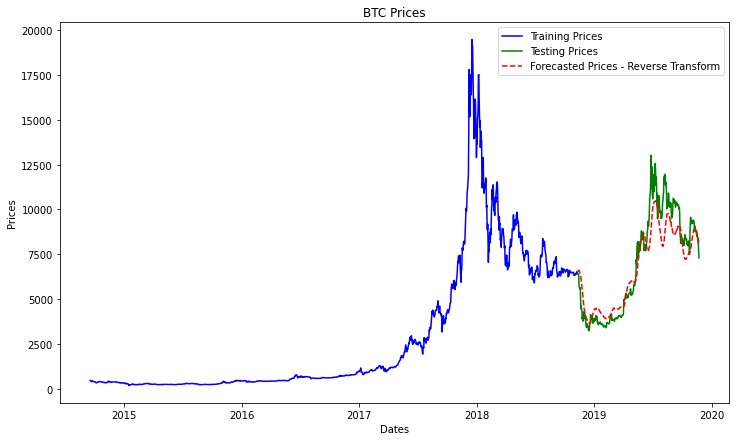

In [25]:
plt.figure(figsize=(12,7))
plt.title('BTC Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_series, color='blue', label='Training Prices')
plt.plot(test_series, color='green', label='Testing Prices')
plt.plot(predicted_stock_price_revtrans_series, color='red', linestyle='--', label='Forecasted Prices - Reverse Transform')
plt.legend();

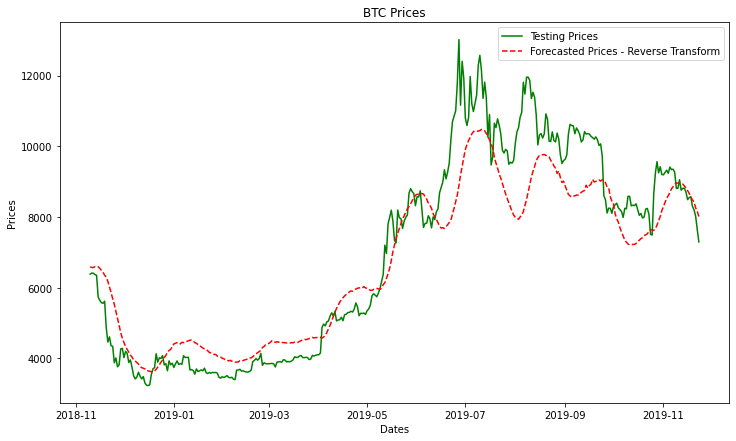

In [26]:
plt.figure(figsize=(12,7))
plt.title('BTC Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(test_series, color='green', label='Testing Prices')
plt.plot(predicted_stock_price_revtrans_series, color='red', linestyle='--', label='Forecasted Prices - Reverse Transform')
plt.legend();